In [86]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
reps=5
nn=[10,15,20,25,30,35,40,45,50,55,60,80,100,120,140]

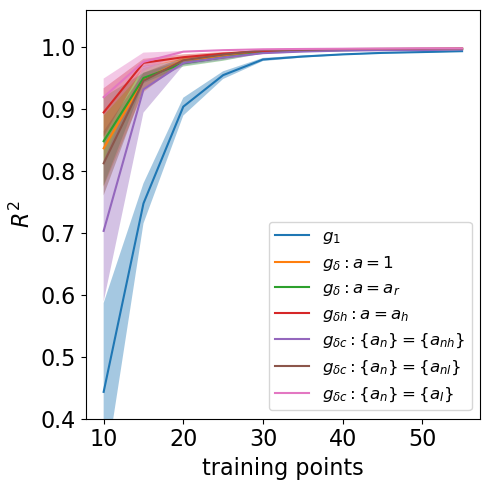

In [124]:
R2_s=pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/csv_files/DiscrepR2TrainNVaryDefinitive.csv",header=None).values.reshape(7,len(nn),2,reps)

plt.rcParams["figure.figsize"] = (5,5)
fontS=16


o=0
lim=0
lim2=10
y_lim=[0.4,1.06]

plt.plot(nn[lim:lim2],R2_s.mean(axis=3)[:,lim:lim2,o].T)
plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'],prop={'size': 12})
for i in range(7):
    plt.fill_between(nn[lim:lim2], R2_s.mean(axis=3)[i,lim:lim2,o]+R2_s.std(axis=3)[i,lim:lim2,o], R2_s.mean(axis=3)[i,lim:lim2,o]-R2_s.std(axis=3)[i,lim:lim2,o],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)

plt.tight_layout()
plt.savefig('figures/WeavingDTDiscrepATAT.pdf' )



In [125]:
R2_s

array([[[[0.45661652, 0.62165511, 0.30147409, 0.2609576 , 0.57603222],
         [0.7329036 , 0.75870806, 0.75347829, 0.79186541, 0.73792297]],

        [[0.77316207, 0.73795742, 0.76726478, 0.68832642, 0.7717557 ],
         [0.84812373, 0.86857903, 0.86494982, 0.85336626, 0.87719548]],

        [[0.91583312, 0.87587243, 0.90594363, 0.910662  , 0.911452  ],
         [0.90531343, 0.88834578, 0.90304023, 0.90930188, 0.92225456]],

        ...,

        [[0.9975251 , 0.99720919, 0.99717695, 0.99755239, 0.99776006],
         [0.99371487, 0.99193633, 0.9943589 , 0.99336815, 0.99420768]],

        [[0.99804771, 0.99804765, 0.99796385, 0.99794018, 0.99808323],
         [0.99519229, 0.99405509, 0.99484873, 0.99518597, 0.99472064]],

        [[0.99825406, 0.99818772, 0.99822128, 0.99830043, 0.99826628],
         [0.99615818, 0.99620271, 0.99635857, 0.99633193, 0.99617434]]],


       [[[0.87048006, 0.91644979, 0.8522296 , 0.81149447, 0.73281676],
         [0.9159739 , 0.92471212, 0.74105942, 0.8

(7, 2, 5)

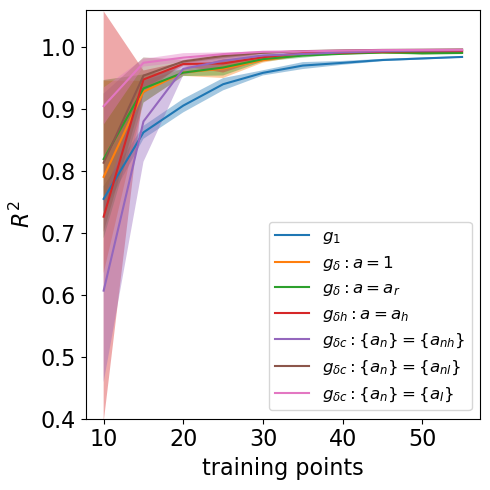

In [126]:
o=1
plt.plot(nn[lim:lim2],R2_s.mean(axis=3)[:,lim:lim2,o].T)
plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'],prop={'size': 12})
for i in range(7):
    plt.fill_between(nn[lim:lim2], R2_s.mean(axis=3)[i,lim:lim2,o]+R2_s.std(axis=3)[i,lim:lim2,o], R2_s.mean(axis=3)[i,lim:lim2,o]-R2_s.std(axis=3)[i,lim:lim2,o],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.tight_layout()
plt.savefig('figures/WeavingDTDiscrepVTAT.pdf' )

R2_s[:,3].shape



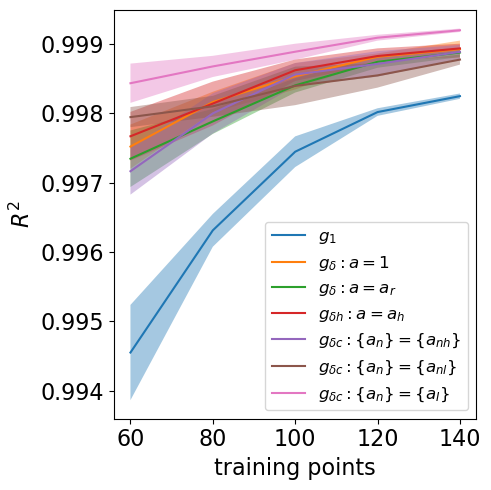

In [109]:
#R2_s=pd.read_csv("DiscrepR2TrainNVaryDefinitive.csv",header=None).values.reshape(7,len(nn),7,reps)

plt.rcParams["figure.figsize"] = (5,5)
fontS=16


o=0
lim=10
lim2=15
y_lim=[0.987,1.001]

plt.plot(nn[lim:lim2],R2_s.mean(axis=3)[:,lim:lim2,o].T)
#plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'],prop={'size': 12})
for i in range(7):
    plt.fill_between(nn[lim:lim2], R2_s.mean(axis=3)[i,lim:lim2,o]+R2_s.std(axis=3)[i,lim:lim2,o], R2_s.mean(axis=3)[i,lim:lim2,o]-R2_s.std(axis=3)[i,lim:lim2,o],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.tight_layout()
plt.savefig('figures/WeavingDTDiscrepATATHigh.pdf' )



(0.987, 1.001)

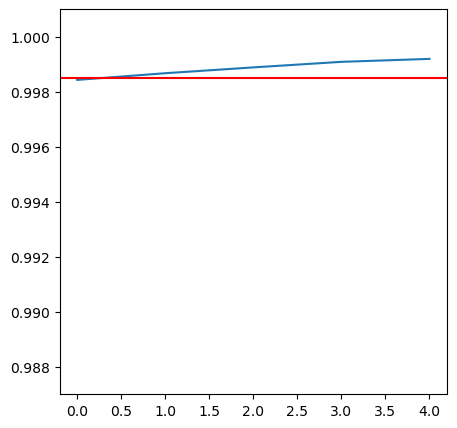

In [110]:
plt.plot(R2_s.mean(axis=3)[:,lim:lim2,o].T[:,6])
plt.axhline(y = 0.9985, color = 'r', linestyle = '-') 
plt.ylim(y_lim)

(7, 2, 5)

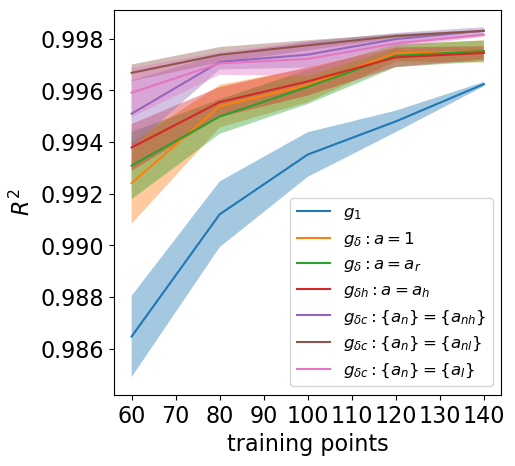

In [112]:
o=1
plt.plot(nn[lim:lim2],R2_s.mean(axis=3)[:,lim:lim2,o].T)
#plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'],prop={'size': 12})
for i in range(7):
    plt.fill_between(nn[lim:lim2], R2_s.mean(axis=3)[i,lim:lim2,o]+R2_s.std(axis=3)[i,lim:lim2,o], R2_s.mean(axis=3)[i,lim:lim2,o]-R2_s.std(axis=3)[i,lim:lim2,o],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('figures/WeavingDTDiscrepVTATHigh.pdf' )

R2_s[:,3].shape



In [113]:
tpr=6

In [114]:
nn[tpr]

40

In [53]:
plt.rcParams["figure.figsize"] = (2,2)

nn

results=pd.DataFrame((R2_s[:,tpr ].mean(axis=2)))

results.index=['\$g_1\$','\$g_{\delta}:a=1\$','\$g_{\delta}:a=a_r\$','\$g_{\delta h}:a=a_h\$','\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$','\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$','\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$']

#results.columns=['A_TAT','V_TAT']

results.style.highlight_min(color = 'pink', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,0,1
\$g_1\$,0.988315,0.974654
\$g_{\delta}:a=1\$,0.995520,0.990073
\$g_{\delta}:a=a_r\$,0.995083,0.989266
\$g_{\delta h}:a=a_h\$,0.996326,0.990998
\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$,0.994399,0.991630
\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$,0.996949,0.994722
\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$,0.997450,0.994402


In [54]:
ands=pd.DataFrame(['&','&','&','&','&','&','&'])

In [55]:
results = pd.DataFrame((R2_s[:,i ].mean(axis=2)))

In [56]:
results=pd.concat([ands,results.iloc[:,0],ands,results.iloc[:,1]],axis=1)

In [79]:
results = pd.DataFrame((R2_s[:,2 ].mean(axis=2)))
results=pd.concat([ands,results.iloc[:,0],ands,results.iloc[:,1]],axis=1)
for i in [7,10]:
    results1=pd.DataFrame((R2_s[:,i ].mean(axis=2)))
    results=pd.concat([results,ands,results1.iloc[:,0],ands,results1.iloc[:,1]],axis=1)
results.index=['\$g_1\$','\$g_{\delta}:a=1\$','\$g_{\delta}:a=a_r\$','\$g_{\delta h}:a=a_h\$','\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$','\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$','\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$']
    

In [80]:
nn

[10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 80, 100, 120, 140]

In [81]:
results.round(3)

,0,0,0,1,0,0,0,1,0,0,0,1
\$g_1\$,&,0.904,&,0.906,&,0.991,&,0.979,&,0.995,&,0.986
\$g_{\delta}:a=1\$,&,0.980,&,0.959,&,0.996,&,0.992,&,0.998,&,0.992
\$g_{\delta}:a=a_r\$,&,0.974,&,0.959,&,0.996,&,0.991,&,0.997,&,0.993
\$g_{\delta h}:a=a_h\$,&,0.984,&,0.973,&,0.997,&,0.993,&,0.998,&,0.994
\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$,&,0.974,&,0.965,&,0.995,&,0.993,&,0.997,&,0.995
\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$,&,0.979,&,0.977,&,0.997,&,0.996,&,0.998,&,0.997
\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$,&,0.993,&,0.983,&,0.998,&,0.995,&,0.998,&,0.996


In [59]:
t=np.array([[0.9958, 0.9964, 0.9958, 0.9946, 0.9967],[0.9920, 0.9889, 0.9895, 0.9912, 0.9888]])

In [60]:
t.mean(axis=1)

array([0.99586, 0.99008])

In [61]:
nn[13]

120

In [62]:
results = pd.DataFrame((R2_s[:,12 ].mean(axis=2)))
results=pd.concat([ands,results.iloc[:,0],ands,results.iloc[:,1]],axis=1)
for i in [13,14]:
    results1=pd.DataFrame((R2_s[:,i ].mean(axis=2)))
    results=pd.concat([results,ands,results1.iloc[:,0],ands,results1.iloc[:,1]],axis=1)
results.index=['\$g_1\$','\$g_{\delta}:a=1\$','\$g_{\delta}:a=a_r\$','\$g_{\delta h}:a=a_h\$','\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$','\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$','\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$']
    

In [63]:
results.round(3)

,0,0,0,1,0,0,0,1,0,0,0,1
\$g_1\$,&,0.997,&,0.994,&,0.998,&,0.995,&,0.998,&,0.996
\$g_{\delta}:a=1\$,&,0.999,&,0.996,&,0.999,&,0.997,&,0.999,&,0.998
\$g_{\delta}:a=a_r\$,&,0.998,&,0.996,&,0.999,&,0.997,&,0.999,&,0.998
\$g_{\delta h}:a=a_h\$,&,0.999,&,0.996,&,0.999,&,0.997,&,0.999,&,0.997
\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$,&,0.999,&,0.997,&,0.999,&,0.998,&,0.999,&,0.998
\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$,&,0.998,&,0.998,&,0.999,&,0.998,&,0.999,&,0.998
\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$,&,0.999,&,0.997,&,0.999,&,0.998,&,0.999,&,0.998


In [69]:
res=pd.DataFrame(R2_s[0].mean(axis=2))
res.index=nn
res.round(3).loc[[20,40,60,80,100,120,140]]

,0,1
20,0.904,0.906
40,0.988,0.975
60,0.995,0.986
80,0.996,0.991
100,0.997,0.994
120,0.998,0.995
140,0.998,0.996


In [70]:
mode_weights = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/modes_weights.csv',index_col=0,delim_whitespace=False,header=0)

mode_weights

#mode_weights=mode_weights.drop(15,axis=0)
#mode_weights=mode_weights.drop(14,axis=0)

meshes=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19']

x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/input/xlabels_EP.txt',delim_whitespace=True,header=None)
x_labels=x_labels.values.flatten().tolist()+mode_weights.columns.tolist()

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/output/ylabels.txt',delim_whitespace=True,header=None)



all_input = []
all_output=[]
all_x=[]
for i in range(len(meshes)):
    val=meshes[i]
    
    inputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    modeweights = np.tile(mode_weights.iloc[i,:].values, (inputData.shape[0],1))
    input_modes = np.concatenate((inputData,modeweights),axis=1)
    all_x.append(torch.tensor(inputData))
    all_input.append(torch.tensor(input_modes))
    all_output.append(torch.tensor(outputData))
    print(val)
    print(np.max(outputData))
#all_input=pd.concat(all_input)
#all_output=pd.concat(all_output
#all_input.columns=x_labels
#all_output.columns=y_labels

01
406.703
02
317.407
03
332.914
04
309.14
05
277.849
06
296.377
07
355.546
08
283.103
09
391.145
10
439.316
11
348.01
12
292.465
13
301.222
14
325.678
15
320.459
16
297.968
17
317.709
18
297.346
19
312.492


In [71]:
train_input=[]
test_input = []
train_output=[]
test_output = []

train_input_modes=[]
test_input_modes = []
train_output_modes=[]
test_output_modes = []

for i in range(len(meshes)):

    X=all_x[i]
    y=all_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input.append(X_train)
    test_input.append(X_test)
    train_output.append(y_train)
    test_output.append(y_test)
    
for i in range(len(meshes)):

    X=all_input[i]
    y=all_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input_modes.append(X_train)
    test_input_modes.append(X_test)
    train_output_modes.append(y_train)
    test_output_modes.append(y_test)

In [72]:
np.array(nn)*17

array([ 170,  255,  340,  425,  510,  595,  680,  765,  850,  935, 1020,
       1360, 1700, 2040, 2380])

In [41]:
reps = 5
train_p = np.array(nn)*17
R2_test = torch.zeros(len(train_p),reps,len(meshes),2)
R2_leftout= torch.zeros(len(train_p),reps,len(meshes),2)
for k in range(len(train_p)):
    for i in range(len(meshes)):
        for j in range(reps):
            X=torch.cat(train_input_modes[0:i]+train_input_modes[i+1:])[:,0:15]
            y=torch.cat(train_output_modes[:i]+train_output_modes[i+1:])
            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y,
                train_size=int(train_p[k]),
                random_state=j
            )
            X_test= torch.cat(test_input_modes[0:i]+test_input_modes[i+1:])[:,0:15]
            y_test=torch.cat(test_output_modes[:i]+test_output_modes[i+1:])
            emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

            meanR, stdR = meanR, stdR = emulator.R2_sample(X_test,y_test,1000)
            R2_test[k,j,i,:]=meanR

            meanR, stdR=emulator.R2_sample(test_input_modes[i][:,0:15],test_output_modes[i],1000) 
            R2_leftout[k,j,i,:] = meanR
            print(R2_test[k,j,i,:])
            print(R2_leftout[k,j,i,:])

0
1
tensor([0.9843, 0.9715])
tensor([0.4017, 0.8137])
0
1
tensor([0.9796, 0.9744])
tensor([0.7335, 0.5852])
0
1
tensor([0.9722, 0.9745])
tensor([0.6909, 0.8253])
0
1
tensor([0.9788, 0.9796])
tensor([0.4834, 0.8352])
0
1
tensor([0.9830, 0.9608])
tensor([0.4435, 0.8458])
0
1
tensor([0.9841, 0.9707])
tensor([0.1519, 0.7795])
0
1
tensor([0.9782, 0.9787])
tensor([0.6668, 0.7159])
0
1
tensor([0.9720, 0.9753])
tensor([-1.2877,  0.5611])
0
1
tensor([0.9786, 0.9808])
tensor([-0.2940,  0.8577])
0
1
tensor([0.9777, 0.9610])
tensor([-0.0928,  0.6462])
0
1
tensor([0.9848, 0.9745])
tensor([0.5928, 0.7543])
0
1
tensor([0.9801, 0.9816])
tensor([0.8552, 0.6979])
0
1
tensor([0.9711, 0.9771])
tensor([0.7174, 0.7572])
0
1
tensor([0.9779, 0.9802])
tensor([0.8897, 0.6709])
0
1
tensor([0.9813, 0.9670])
tensor([0.8730, 0.7303])
0
1
tensor([0.9859, 0.9719])
tensor([-2.9235,  0.3687])
0
1
tensor([0.9776, 0.9787])
tensor([0.7389, 0.7896])
0
1
tensor([0.9833, 0.9775])
tensor([-1.6188,  0.2517])
0
1
tensor([0.9826

1
tensor([0.9891, 0.9886])
tensor([0.9735, 0.9725])
0
1
tensor([0.9893, 0.9826])
tensor([0.9844, 0.9569])
0
1
tensor([0.9916, 0.9856])
tensor([0.9899, 0.9382])
0
1
tensor([0.9915, 0.9834])
tensor([0.9805, 0.9587])
0
1
tensor([0.9894, 0.9842])
tensor([0.8655, 0.3653])
0
1
tensor([0.9900, 0.9872])
tensor([0.7972, 0.8356])
0
1
tensor([0.9896, 0.9835])
tensor([0.8269, 0.4357])
0
1
tensor([0.9919, 0.9862])
tensor([0.7208, 0.4316])
0
1
tensor([0.9908, 0.9800])
tensor([0.7952, 0.6631])
0
1
tensor([0.9896, 0.9843])
tensor([0.8121, 0.8628])
0
1
tensor([0.9887, 0.9879])
tensor([0.8898, 0.8927])
0
1
tensor([0.9891, 0.9841])
tensor([0.8282, 0.7184])
0
1
tensor([0.9905, 0.9857])
tensor([0.5002, 0.7834])
0
1
tensor([0.9904, 0.9812])
tensor([0.8803, 0.8101])
0
1
tensor([0.9923, 0.9834])
tensor([0.6839, 0.7828])
0
1
tensor([0.9894, 0.9864])
tensor([0.6772, 0.7809])
0
1
tensor([0.9913, 0.9846])
tensor([0.6034, 0.6767])
0
1
tensor([0.9931, 0.9870])
tensor([0.5783, 0.7116])
0
1
tensor([0.9935, 0.9824])
t

1
tensor([0.9953, 0.9905])
tensor([-2.8562,  0.2604])
0
1
tensor([0.9961, 0.9924])
tensor([-3.4992,  0.7085])
0
1
tensor([0.9960, 0.9904])
tensor([-4.1178,  0.2788])
0
1
tensor([0.9953, 0.9923])
tensor([0.5494, 0.9291])
0
1
tensor([0.9948, 0.9919])
tensor([0.5430, 0.9615])
0
1
tensor([0.9958, 0.9907])
tensor([0.6375, 0.9295])
0
1
tensor([0.9958, 0.9924])
tensor([0.5439, 0.9603])
0
1
tensor([0.9953, 0.9918])
tensor([0.4470, 0.9496])
0
1
tensor([0.9954, 0.9921])
tensor([0.9838, 0.9566])
0
1
tensor([0.9937, 0.9910])
tensor([0.9418, 0.9688])
0
1
tensor([0.9954, 0.9898])
tensor([0.7786, 0.9115])
0
1
tensor([0.9961, 0.9922])
tensor([0.8048, 0.9327])
0
1
tensor([0.9959, 0.9911])
tensor([0.7952, 0.9430])
0
1
tensor([0.9957, 0.9910])
tensor([0.8808, 0.9588])
0
1
tensor([0.9944, 0.9912])
tensor([0.9819, 0.9210])
0
1
tensor([0.9957, 0.9903])
tensor([0.8141, 0.8951])
0
1
tensor([0.9962, 0.9927])
tensor([0.8854, 0.9241])
0
1
tensor([0.9954, 0.9914])
tensor([0.9792, 0.9392])
0
1
tensor([0.9942, 0.99

1
tensor([0.9965, 0.9938])
tensor([0.7351, 0.7476])
0
1
tensor([0.9965, 0.9935])
tensor([0.7758, 0.9336])
0
1
tensor([0.9968, 0.9940])
tensor([0.9817, 0.9325])
0
1
tensor([0.9965, 0.9922])
tensor([0.9741, 0.8045])
0
1
tensor([0.9967, 0.9951])
tensor([0.8077, 0.8121])
0
1
tensor([0.9967, 0.9943])
tensor([0.9785, 0.7922])
0
1
tensor([0.9964, 0.9926])
tensor([-0.7572,  0.7943])
0
1
tensor([0.9963, 0.9919])
tensor([-2.5062,  0.6261])
0
1
tensor([0.9956, 0.9921])
tensor([-0.1368,  0.6770])
0
1
tensor([0.9967, 0.9944])
tensor([-1.3533,  0.6852])
0
1
tensor([0.9965, 0.9937])
tensor([0.3466, 0.4880])
0
1
tensor([0.9964, 0.9928])
tensor([0.3815, 0.9532])
0
1
tensor([0.9957, 0.9915])
tensor([0.8556, 0.9377])
0
1
tensor([0.9964, 0.9914])
tensor([0.2944, 0.9507])
0
1
tensor([0.9968, 0.9938])
tensor([0.8142, 0.9354])
0
1
tensor([0.9967, 0.9933])
tensor([0.5068, 0.9148])
0
1
tensor([0.9966, 0.9930])
tensor([0.4738, 0.8675])
0
1
tensor([0.9965, 0.9901])
tensor([0.5090, 0.8814])
0
1
tensor([0.9962, 0.

1
tensor([0.9969, 0.9955])
tensor([0.8904, 0.7928])
0
1
tensor([0.9975, 0.9935])
tensor([0.9769, 0.7727])
0
1
tensor([0.9972, 0.9940])
tensor([0.9707, 0.7765])
0
1
tensor([0.9970, 0.9948])
tensor([0.9396, 0.7595])
0
1
tensor([0.9969, 0.9943])
tensor([0.9234, 0.8049])
0
1
tensor([0.9972, 0.9953])
tensor([0.9371, 0.6904])
0
1
tensor([0.9972, 0.9936])
tensor([0.9376, 0.7084])
0
1
tensor([0.9974, 0.9943])
tensor([0.9331, 0.7942])
0
1
tensor([0.9972, 0.9946])
tensor([0.7189, 0.7368])
0
1
tensor([0.9976, 0.9939])
tensor([0.4627, 0.7087])
0
1
tensor([0.9972, 0.9950])
tensor([0.4608, 0.8734])
0
1
tensor([0.9971, 0.9939])
tensor([0.5879, 0.8290])
0
1
tensor([0.9971, 0.9944])
tensor([0.8789, 0.9082])
0
1
tensor([0.9971, 0.9951])
tensor([0.3658, 0.8161])
0
1
tensor([0.9975, 0.9941])
tensor([0.8719, 0.9012])
0
1
tensor([0.9970, 0.9958])
tensor([0.9494, 0.7177])
0
1
tensor([0.9976, 0.9945])
tensor([0.7896, 0.8979])
0
1
tensor([0.9970, 0.9947])
tensor([0.8542, 0.7012])
0
1
tensor([0.9974, 0.9950])
t

1
tensor([0.9973, 0.9947])
tensor([0.0415, 0.8939])
0
1
tensor([0.9974, 0.9954])
tensor([-0.4592,  0.8928])
0
1
tensor([0.9976, 0.9954])
tensor([-0.1527,  0.9126])
0
1
tensor([0.9831, 0.9884])
tensor([0.8576, 0.7246])
0
1
tensor([0.9719, 0.9802])
tensor([0.7732, 0.5022])
0
1
tensor([0.9733, 0.9875])
tensor([0.7433, 0.7271])
0
1
tensor([0.9742, 0.9911])
tensor([0.8059, 0.8469])
0
1
tensor([0.9699, 0.9837])
tensor([0.8803, 0.2149])
0
1
tensor([0.9770, 0.9855])
tensor([0.2984, 0.9278])
0
1
tensor([0.9703, 0.9859])
tensor([-1.5358,  0.5687])
0
1
tensor([0.9728, 0.9842])
tensor([-2.2626,  0.8082])
0
1
tensor([0.9771, 0.9905])
tensor([-2.0798,  0.8252])
0
1
tensor([0.9719, 0.9863])
tensor([-2.0171,  0.8949])
0
1
tensor([0.9802, 0.9864])
tensor([0.6014, 0.8032])
0
1
tensor([0.9754, 0.9896])
tensor([0.5640, 0.7132])
0
1
tensor([0.9756, 0.9899])
tensor([0.5396, 0.7341])
0
1
tensor([0.9632, 0.9910])
tensor([0.6044, 0.8517])
0
1
tensor([0.9697, 0.9802])
tensor([0.6051, 0.7155])
0
1
tensor([0.9825

1
tensor([0.9763, 0.9839])
tensor([ 0.7900, -0.4955])
0
1
tensor([0.9810, 0.9860])
tensor([0.9373, 0.7176])
0
1
tensor([0.9594, 0.9828])
tensor([0.9677, 0.9622])
0
1
tensor([0.9764, 0.9793])
tensor([0.9725, 0.9406])
0
1
tensor([0.9803, 0.9797])
tensor([0.9725, 0.9606])
0
1
tensor([0.9798, 0.9883])
tensor([0.9771, 0.9029])
0
1
tensor([0.9764, 0.9839])
tensor([0.9723, 0.9649])
0
1
tensor([0.9725, 0.9852])
tensor([0.8895, 0.5559])
0
1
tensor([0.9753, 0.9811])
tensor([0.7621, 0.8478])
0
1
tensor([0.9739, 0.9848])
tensor([0.9404, 0.6101])
0
1
tensor([0.9812, 0.9881])
tensor([0.8545, 0.5190])
0
1
tensor([0.9801, 0.9847])
tensor([0.7585, 0.7358])
0
1
tensor([0.9819, 0.9857])
tensor([0.8437, 0.8087])
0
1
tensor([0.9743, 0.9830])
tensor([0.9480, 0.7436])
0
1
tensor([0.9756, 0.9859])
tensor([0.7526, 0.9545])
0
1
tensor([0.9805, 0.9885])
tensor([0.7938, 0.7035])
0
1
tensor([0.9795, 0.9871])
tensor([0.7889, 0.7368])
0
1
tensor([0.9794, 0.9843])
tensor([0.7277, 0.7479])
0
1
tensor([0.9758, 0.9746])

KeyboardInterrupt: 

In [42]:
R2_test

tensor([[[[0.9843, 0.9715],
          [0.9841, 0.9707],
          [0.9848, 0.9745],
          ...,
          [0.9799, 0.9785],
          [0.9778, 0.9755],
          [0.9763, 0.9788]],

         [[0.9796, 0.9744],
          [0.9782, 0.9787],
          [0.9801, 0.9816],
          ...,
          [0.9797, 0.9720],
          [0.9811, 0.9703],
          [0.9805, 0.9695]],

         [[0.9722, 0.9745],
          [0.9720, 0.9753],
          [0.9711, 0.9771],
          ...,
          [0.9837, 0.9764],
          [0.9752, 0.9727],
          [0.9842, 0.9733]],

         [[0.9788, 0.9796],
          [0.9786, 0.9808],
          [0.9779, 0.9802],
          ...,
          [0.9855, 0.9813],
          [0.9868, 0.9721],
          [0.9866, 0.9813]],

         [[0.9830, 0.9608],
          [0.9777, 0.9610],
          [0.9813, 0.9670],
          ...,
          [0.9814, 0.9633],
          [0.9796, 0.9601],
          [0.9854, 0.9572]]],


        [[[0.9911, 0.9812],
          [0.9917, 0.9803],
          [0.9924